In [54]:
# импорт библиотек

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
# задание настроек для извлечения признаков

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

op = OptionParser()
op.add_option("--lsa",
              dest="n_components", type="int",
              help="Preprocess documents with latent semantic analysis.")
op.add_option("--no-minibatch",
              action="store_false", dest="minibatch", default=True,
              help="Use ordinary k-means algorithm (in batch mode).")
op.add_option("--no-idf",
              action="store_false", dest="use_idf", default=True,
              help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing",
              action="store_true", default=False,
              help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=1000,
              help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose",
              action="store_true", dest="verbose", default=False,
              help="Print progress reports inside k-means algorithm.")

print(__doc__)
op.print_help()

def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.


In [58]:
# Загрузка 4 различных категорий текстов из библиотеки текстов 20ng
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
3387 documents
4 categories



In [61]:
# извлечение массива меток для каждого текста

labels = dataset.target
true_k = np.unique(labels).shape[0]

# Извлечение признаков

In [62]:
## извлечение признаков из данных
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=opts.n_features,
                                   stop_words='english', alternate_sign=False,
                                   norm=None)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=opts.n_features,
                                       stop_words='english',
                                       alternate_sign=False, norm='l2')
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=opts.use_idf)
    print(vectorizer)
X = vectorizer.fit_transform(dataset.data)
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.5, max_features=1000,
                min_df=2, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)
done in 1.108365s
n_samples: 3387, n_features: 1000



In [63]:
# #############################################################################
# создание таблицы данных для удобного хранения и визуализации
df = pd.DataFrame(data=X.toarray(),columns=vectorizer.get_feature_names())
df['__labels__'] = labels
df.head(5)

,00,000,10,100,11,12,128,13,14,15,...,xv,year,years,yes,york,young,zip,zoo,zoology,__labels__
0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.098475,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.00000,0.0,0.185695,0.0,0.0,0.0,0.146367,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.03921,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.028484,...,0.0,0.031561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# Метод снижения размерности (t-SNE) для визуализации данных

In [10]:
# #############################################################################
# импорт библиотеки TSNE и создание объекта для нелинейного снижения размерности (алгортм t-SNE)
from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)
t0 = time()
tsne.fit(df.drop('__labels__', axis=1))
print("done in %fs" % (time() - t0))

done in 52.625978s


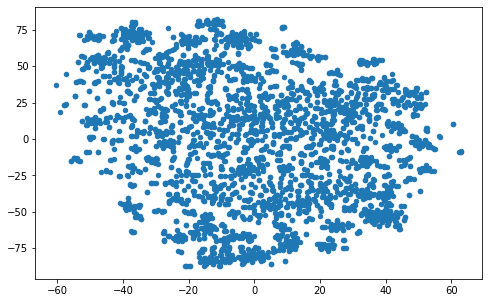

Рисунок 1 - Карта объектов расположеных в двумерном признаковом пространстве


In [72]:
plt.figure(figsize=(8,5))
plt.scatter(tsne.embedding_[:, 0], 
            tsne.embedding_[:, 1], s=20);
plt.show()
print('Рисунок 1 - Карта объектов расположеных в двумерном признаковом пространстве')

# Сравнение различных алгоритмов кластеризации

*Алгоритмы применялись практически без настройки, при детальном изучении каждого метода и изменении гиперпараметров возможны гораздо более хорошие результаты*

> # k-means

https://scikit-learn.org/stable/modules/clustering.html#k-means  
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

Short description

| Method name | Parameters | Scalability | Usecase | Geometry (metric used) |
|-------------|------------|-------------|---------|------------------------|
| K-Means | number of clusters | Very large *n_samples*, medium *n_clusters* with MiniBatch code | General-purpose, even cluster size, flat geometry, not too many clusters | Distances between points  |

In [65]:
# #############################################################################
# подготовка к кластеризации k-means

if opts.minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=opts.verbose)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)
print("Clustering sparse data with %s" % km)

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=4, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=False)


In [66]:
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

done in 0.076s



In [67]:
# Вывод результатов кластеризации.

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))
print("Accuracy score: %0.3f"
      % metrics.accuracy_score(labels, km.labels_))
print()

Homogeneity: 0.439
Completeness: 0.438
V-measure: 0.438
Adjusted Rand-Index: 0.393
Silhouette Coefficient: 0.016
Accuracy score: 0.218



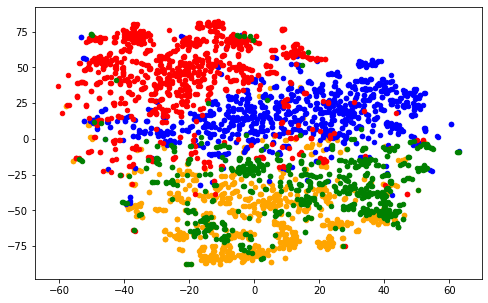

Рисунок 2 - Карта объектов, помеченных в соответствии со своими классами 


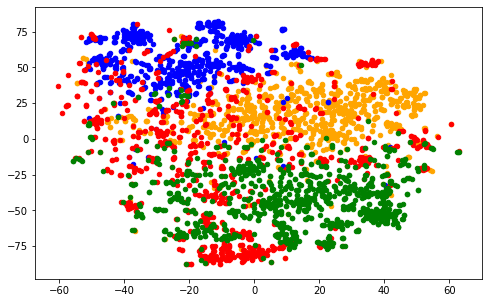

Рисунок 3 - Карта объектов, помеченных в соответствии результатами работы алгоритма кластеризации K-means


In [73]:
plt.figure(figsize=(8,5))
plt.scatter(tsne.embedding_[df['__labels__'] == 0, 0], 
            tsne.embedding_[df['__labels__'] == 0, 1], color='orange', s=20);
plt.scatter(tsne.embedding_[df['__labels__'] == 1, 0], 
            tsne.embedding_[df['__labels__'] == 1, 1], color='blue', s=20);
plt.scatter(tsne.embedding_[df['__labels__'] == 2, 0], 
            tsne.embedding_[df['__labels__'] == 2, 1], color='red', s=20);
plt.scatter(tsne.embedding_[df['__labels__'] == 3, 0], 
            tsne.embedding_[df['__labels__'] == 3, 1], color='green', s=20);
plt.show()
print('Рисунок 2 - Карта объектов, помеченных в соответствии со своими классами ')

plt.figure(figsize=(8,5))
plt.scatter(tsne.embedding_[km.labels_ == 0, 0], 
            tsne.embedding_[km.labels_ == 0, 1], color='orange', s=20);
plt.scatter(tsne.embedding_[km.labels_ == 1, 0], 
            tsne.embedding_[km.labels_ == 1, 1], color='blue', s=20);
plt.scatter(tsne.embedding_[km.labels_ == 2, 0], 
            tsne.embedding_[km.labels_ == 2, 1], color='red', s=20);
plt.scatter(tsne.embedding_[km.labels_ == 3, 0], 
            tsne.embedding_[km.labels_ == 3, 1], color='green', s=20);
plt.show()
print('Рисунок 3 - Карта объектов, помеченных в соответствии результатами работы алгоритма кластеризации K-means')

In [ ]:
# X?
# X.data
# X.indices
# X.toarray().shape
# labels
# km.labels_

In [69]:
if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

Top terms per cluster:
Cluster 0: graphics ac uk image university thanks file files computer com
Cluster 1: space nasa henry access gov digex toronto pat shuttle alaska
Cluster 2: com keith sgi posting nntp host caltech article livesey university
Cluster 3: god com people jesus sandvik don christian article say think


># Self-organizing maps

In [74]:
# импорт библиотеки MiniSom для работы с картами кохонена
from minisom import MiniSom

In [75]:
som_shape = (1, 4)
som = MiniSom(som_shape[0], som_shape[1], opts.n_features, sigma=0.3, learning_rate=0.5,
             neighborhood_function='gaussian', random_seed=15) # initialization of 100x100 SOM

In [76]:
t0 = time()
som.train(X.toarray(), 2000, verbose=True) # trains the SOM with 100 iterations
print("done in %fs" % (time() - t0))

 [  650 / 2000 ]  32% - 0:00:00 left 

 [ 1373 / 2000 ]  69% - 0:00:00 left 

 [ 2000 / 2000 ] 100% - 0:00:00 left 


 quantization error: 1.0032453743667717
done in 0.682723s


In [77]:
winner_coordinates = np.array([som.winner(x) for x in X.toarray()]).T
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)
winner_coordinates.shape

(2, 3387)

In [78]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, cluster_index))
print("Completeness: %0.3f" % metrics.completeness_score(labels, cluster_index))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, cluster_index))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, cluster_index))
print("Accuracy score: %0.3f"
      % metrics.accuracy_score(labels, cluster_index))
print()

Homogeneity: 0.177
Completeness: 0.244
V-measure: 0.205
Adjusted Rand-Index: 0.142
Accuracy score: 0.335



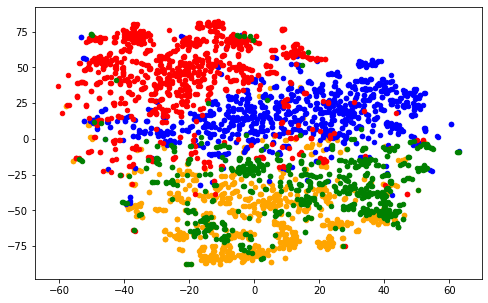

Рисунок 4 - Карта объектов, помеченных в соответствии со своими классами 


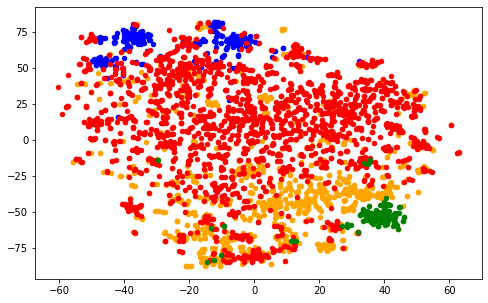

Рисунок 5 - Карта объектов, помеченных в соответствии результатами работы алгоритма кластеризации SOM


In [80]:
plt.figure(figsize=(8,5))
plt.scatter(tsne.embedding_[df['__labels__'] == 0, 0], 
            tsne.embedding_[df['__labels__'] == 0, 1], color='orange', s=20);
plt.scatter(tsne.embedding_[df['__labels__'] == 1, 0], 
            tsne.embedding_[df['__labels__'] == 1, 1], color='blue', s=20);
plt.scatter(tsne.embedding_[df['__labels__'] == 2, 0], 
            tsne.embedding_[df['__labels__'] == 2, 1], color='red', s=20);
plt.scatter(tsne.embedding_[df['__labels__'] == 3, 0], 
            tsne.embedding_[df['__labels__'] == 3, 1], color='green', s=20);
plt.show()
print('Рисунок 4 - Карта объектов, помеченных в соответствии со своими классами ')


plt.figure(figsize=(8,5))
plt.scatter(tsne.embedding_[cluster_index == 0, 0], 
            tsne.embedding_[cluster_index == 0, 1], color='orange', s=20);
plt.scatter(tsne.embedding_[cluster_index == 1, 0], 
            tsne.embedding_[cluster_index == 1, 1], color='blue', s=20);
plt.scatter(tsne.embedding_[cluster_index == 2, 0], 
            tsne.embedding_[cluster_index == 2, 1], color='red', s=20);
plt.scatter(tsne.embedding_[cluster_index == 3, 0], 
            tsne.embedding_[cluster_index == 3, 1], color='green', s=20);
plt.show()
print('Рисунок 5 - Карта объектов, помеченных в соответствии результатами работы алгоритма кластеризации SOM')

># Spectral Clustering  
https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering  
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering  

Short description

| Method name | Parameters | Scalability | Usecase | Geometry (metric used) |
|-------------|------------|-------------|---------|------------------------|
| Spectral clustering | number of clusters | Medium *n_samples*, small *n_clusters* | Few clusters, even cluster size, non-flat geometry | Graph distance (e.g. nearest-neighbor graph)  |

In [81]:
from sklearn.cluster import SpectralClustering

In [83]:
sc = SpectralClustering(n_clusters=4,
                        assign_labels="discretize",
                        random_state=17)

In [84]:
t0 = time()
sc.fit(X.toarray())
print("done in %fs" % (time() - t0))

done in 2.483137s


In [85]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, sc.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, sc.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, sc.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, sc.labels_))
print("Accuracy score: %0.3f"
      % metrics.accuracy_score(labels, sc.labels_))
print()

Homogeneity: 0.306
Completeness: 0.398
V-measure: 0.346
Adjusted Rand-Index: 0.238
Accuracy score: 0.156



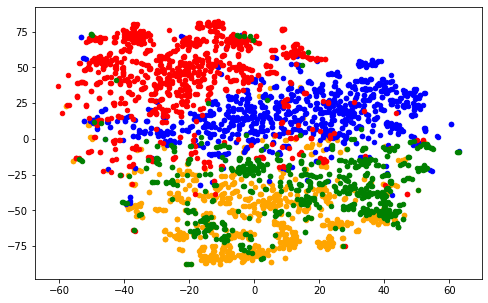

Рисунок 6 - Карта объектов, помеченных в соответствии со своими классами 


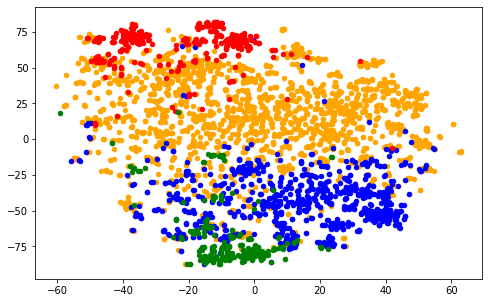

Рисунок 7 - Карта объектов, помеченных в соответствии результатами работы алгоритма кластеризации Spectral Clustering


In [86]:
plt.figure(figsize=(8,5))
plt.scatter(tsne.embedding_[df['__labels__'] == 0, 0], 
            tsne.embedding_[df['__labels__'] == 0, 1], color='orange', s=20);
plt.scatter(tsne.embedding_[df['__labels__'] == 1, 0], 
            tsne.embedding_[df['__labels__'] == 1, 1], color='blue', s=20);
plt.scatter(tsne.embedding_[df['__labels__'] == 2, 0], 
            tsne.embedding_[df['__labels__'] == 2, 1], color='red', s=20);
plt.scatter(tsne.embedding_[df['__labels__'] == 3, 0], 
            tsne.embedding_[df['__labels__'] == 3, 1], color='green', s=20);
plt.show()
print('Рисунок 6 - Карта объектов, помеченных в соответствии со своими классами ')


plt.figure(figsize=(8,5))
plt.scatter(tsne.embedding_[sc.labels_ == 0, 0], 
            tsne.embedding_[sc.labels_ == 0, 1], color='orange', s=20);
plt.scatter(tsne.embedding_[sc.labels_ == 1, 0], 
            tsne.embedding_[sc.labels_ == 1, 1], color='blue', s=20);
plt.scatter(tsne.embedding_[sc.labels_ == 2, 0], 
            tsne.embedding_[sc.labels_ == 2, 1], color='red', s=20);
plt.scatter(tsne.embedding_[sc.labels_ == 3, 0], 
            tsne.embedding_[sc.labels_ == 3, 1], color='green', s=20);
plt.show()
print('Рисунок 7 - Карта объектов, помеченных в соответствии результатами работы алгоритма кластеризации Spectral Clustering')

> # Agglomerative Clustering  
https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering  
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering    

Short description

| Method name | Parameters | Scalability | Usecase | Geometry (metric used) |
|-------------|------------|-------------|---------|------------------------|
| Agglomerative clustering          | number of clusters or distance threshold, linkage type, distance          | Large *n_samples* and *n_clusters*           | Many clusters, possibly connectivity constraints, non Euclidean distances       | Any pairwise distance                      |

In [22]:
from sklearn.cluster import AgglomerativeClustering

In [30]:
ac = AgglomerativeClustering(n_clusters=4,
                            affinity='euclidean',
                            memory=None,
                            connectivity=None,
                            compute_full_tree='auto',
                            linkage='ward',
                            pooling_func='deprecated',
                            distance_threshold=None,)

In [31]:
t0 = time()
ac.fit(X.toarray())
print("done in %fs" % (time() - t0))

done in 6.824088s


In [32]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, ac.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, ac.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, ac.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, ac.labels_))
print("Accuracy score: %0.3f"
      % metrics.accuracy_score(labels, ac.labels_))
print()

Homogeneity: 0.222
Completeness: 0.396
V-measure: 0.284
Adjusted Rand-Index: 0.128
Accuracy score: 0.199



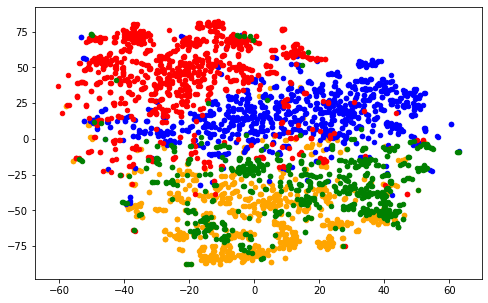

Рисунок 8 - Карта объектов, помеченных в соответствии со своими классами 


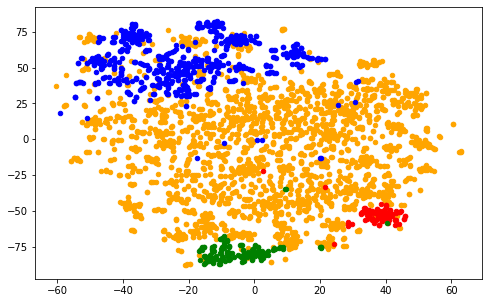

Рисунок 9 - Карта объектов, помеченных в соответствии результатами работы алгоритма                                                         кластеризации Agglomerative Clustering


In [87]:
plt.figure(figsize=(8,5))
plt.scatter(tsne.embedding_[df['__labels__'] == 0, 0], 
            tsne.embedding_[df['__labels__'] == 0, 1], color='orange', s=20);
plt.scatter(tsne.embedding_[df['__labels__'] == 1, 0], 
            tsne.embedding_[df['__labels__'] == 1, 1], color='blue', s=20);
plt.scatter(tsne.embedding_[df['__labels__'] == 2, 0], 
            tsne.embedding_[df['__labels__'] == 2, 1], color='red', s=20);
plt.scatter(tsne.embedding_[df['__labels__'] == 3, 0], 
            tsne.embedding_[df['__labels__'] == 3, 1], color='green', s=20);
plt.show()
print('Рисунок 8 - Карта объектов, помеченных в соответствии со своими классами ')


plt.figure(figsize=(8,5))
plt.scatter(tsne.embedding_[ac.labels_ == 0, 0], 
            tsne.embedding_[ac.labels_ == 0, 1], color='orange', s=20);
plt.scatter(tsne.embedding_[ac.labels_ == 1, 0], 
            tsne.embedding_[ac.labels_ == 1, 1], color='blue', s=20);
plt.scatter(tsne.embedding_[ac.labels_ == 2, 0], 
            tsne.embedding_[ac.labels_ == 2, 1], color='red', s=20);
plt.scatter(tsne.embedding_[ac.labels_ == 3, 0], 
            tsne.embedding_[ac.labels_ == 3, 1], color='green', s=20);
plt.show()
print('Рисунок 9 - Карта объектов, помеченных в соответствии результатами работы алгоритма \
                                                        кластеризации Agglomerative Clustering')

## Черновики:
*Также была проведена попытка применить алгоритмы, которые не имеют гиперпараметров связанных с числом кластеров, результаты оказались неудовлетворительными. Хотя, вероятно, при детальном изучении и настройке можно их грамотно настроить и получить более качественные результаты*

# Affinity Propagation

Возможные алгоритмы в scikit-learn: \
https://scikit-learn.org/stable/modules/clustering.html

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation.fit \
https://scikit-learn.org/stable/auto_examples/cluster/plot_affinity_propagation.html#sphx-glr-auto-examples-cluster-plot-affinity-propagation-py


In [34]:
from sklearn.cluster import AffinityPropagation

In [35]:
# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(damping = 0.5,
                         preference=-500, 
                         verbose=True, 
                         max_iter=20)

In [39]:
t0 = time()
af = af.fit(X.toarray())
print("done in %fs" % (time() - t0))
cluster_centers_indices = af.cluster_centers_indices_


n_clusters_ = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % n_clusters_)

Did not converge
done in 10.609921s
Estimated number of clusters: 3387


In [40]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, af.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, af.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, af.labels_))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels, af.labels_))
print("Accuracy score: %0.3f"
      % metrics.accuracy_score(labels, af.labels_))
print()

# #############################################################################

Homogeneity: 1.000
Completeness: 0.169
V-measure: 0.289
Adjusted Rand Index: 0.000
Accuracy score: 0.001



# mean-shift

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift \
https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html#sphx-glr-auto-examples-cluster-plot-mean-shift-py


In [41]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [42]:
bandwidth = estimate_bandwidth(X.toarray(), quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)

In [43]:
t0 = time()
ms.fit(X.toarray())
print("done in %fs" % (time() - t0))
##labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

done in 11.771121s
number of estimated clusters : 4


In [45]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, ms.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, ms.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, ms.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, ms.labels_))
print("Accuracy score: %0.3f"
      % metrics.accuracy_score(labels, ms.labels_))
print()

Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand-Index: 0.000
Accuracy score: 0.236



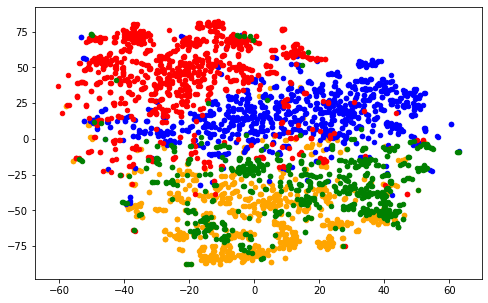

Рисунок ... - Карта объектов, помеченных в соответствии со своими классами 


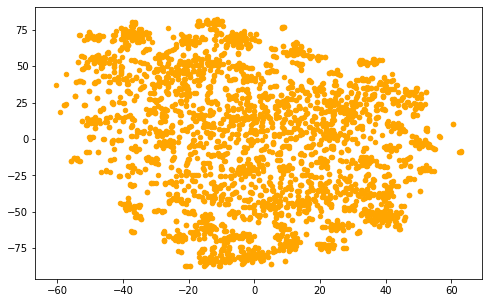

Рисунок ... - Карта объектов, помеченных в соответствии результатами работы алгоритма кластеризации mean-shift


In [46]:
plt.figure(figsize=(8,5))
plt.scatter(tsne.embedding_[df['__labels__'] == 0, 0], 
            tsne.embedding_[df['__labels__'] == 0, 1], color='orange', s=20);
plt.scatter(tsne.embedding_[df['__labels__'] == 1, 0], 
            tsne.embedding_[df['__labels__'] == 1, 1], color='blue', s=20);
plt.scatter(tsne.embedding_[df['__labels__'] == 2, 0], 
            tsne.embedding_[df['__labels__'] == 2, 1], color='red', s=20);
plt.scatter(tsne.embedding_[df['__labels__'] == 3, 0], 
            tsne.embedding_[df['__labels__'] == 3, 1], color='green', s=20);
plt.show()
print('Рисунок ... - Карта объектов, помеченных в соответствии со своими классами ')


plt.figure(figsize=(8,5))
plt.scatter(tsne.embedding_[ms.labels_ == 0, 0], 
            tsne.embedding_[ms.labels_ == 0, 1], color='orange', s=20);
plt.scatter(tsne.embedding_[ms.labels_ == 1, 0], 
            tsne.embedding_[ms.labels_ == 1, 1], color='blue', s=20);
plt.scatter(tsne.embedding_[ms.labels_ == 2, 0], 
            tsne.embedding_[ms.labels_ == 2, 1], color='red', s=20);
plt.scatter(tsne.embedding_[ms.labels_ == 3, 0], 
            tsne.embedding_[ms.labels_ == 3, 1], color='green', s=20);
plt.show()
print('Рисунок ... - Карта объектов, помеченных в соответствии результатами работы алгоритма кластеризации mean-shift')